## **A Map of Test Cricket Grounds of the World**

A look at visualisations using maps in Python.  I'll use a data set I've collated of coordinates of all the main current test match cricket grounds and over the next few posts I'll plot them in different map based packages, making use of those packages specific functionality where possible.

### **Basemap Package**

Firstly I'm going to use Basemap to create a simple visualisation of the location of all the grounds, linked to every other ground using [great circles](https://en.wikipedia.org/wiki/Great-circle_distance).  We will hopefully end up with a visualisation that looks something along the lines of a [route map of a major airline](http://travelisfree.com/wp-content/uploads/2017/01/Iberia-route-map.png "route map example") that travels all round the world.

### **Purpose?**

This is just going to be a static visualisation and on its own will hold minimal insight.  On a general level knowing the distance between venues in sports may provide a line of insight into performance, though for test cricket purposes this factor is probably negligible as teams tend to travel well in advance of matches.

For example, if a London based Premier League football team like Arsenal plays a European game in Moscow on a Thursday evening followed by an away league game in Newcastle on Sunday afternoon, how far have they travelled in the last 4 days?  How much further have they travelled than Newcastle in the time period?  Should we expect an adverse effect on performance? Can we quantify that effect in terms of expected goals scored/conceded if so?

What about a tennis player who makes the final of a tournament in France on a Sunday and whos next match is in China on a Tuesday?  Should we expect that players performance level on Tuesday to be significantly worse than Sundays? Does it drop off more than if they had to go from Germany to the UK in the same length of time?

I'm not going to be able to answer those questions here, but collating the data of distance a player/team travelled would be involved in such an analysis.  In that case knowing the distance between venues would be useful.

### **The Data**

Lets start by importing our data, which is in a csv file.

In [5]:
#Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from itertools import combinations

#Load our dataset as a DataFrame
all_grounds_df = pd.read_csv('https://eddiesport.github.io/projects/test_grounds.csv', header=0, index_col=0)
                             
#Check data
print(all_grounds_df.head(10))
print(all_grounds_df.info())

          ground        lat         lng     location       team
0          Lords  51.529603   -0.172906       London    England
1       The Oval  51.483816   -0.115138       London    England
2   Old Trafford  53.456806   -2.287469   Manchester    England
3   Trent Bridge  52.936857   -1.132165   Nottingham    England
4     Headingley  53.817661   -1.581978        Leeds    England
5      Edgbaston  52.455658   -1.902610   Birmingham    England
6      Rose Bowl  50.924125   -1.321760  Southampton    England
7            MCG -37.820000  144.983333    Melbourne  Australia
8            SCG -33.891667  151.224722       Sydney  Australia
9  Adelaide Oval -34.915556  138.596111     Adelaide  Australia
<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 58
Data columns (total 5 columns):
ground      59 non-null object
lat         59 non-null float64
lng         59 non-null float64
location    59 non-null object
team        59 non-null object
dtypes: float64(2), object(3)
memory 

We have coordinate data for 59 grounds.  To draw our great circles we are going to need coordinate combinations for all possible pairs of grounds. Firstly I'll extract from the DataFrame a tuple of coordinate pairs for each ground.

In [6]:
#Create a list of tuples of all grounds coordinates
#%%timeit - 1.66 ms ± 84.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

#Set up our empty list
ground_tuples = []

#Iterate over our dataframe to create our required variables
for row in all_grounds_df.itertuples():
    ground_lat = row.lat
    ground_lng = row.lng
    #Append new sets of tuples to our list
    ground_tuple = ground_lat, ground_lng
    ground_tuples.append(ground_tuple)

#Check an element of our list    
print(ground_tuples[0])

(51.529603, -0.172906)


**Note:**  I've commented out a timeit command in that code cell. In testing the timeit result shown for this cell (minus the print call) was obtained and was as displayed, 1.66 ms ± 84.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each).

I mention this as virtually the same for loop method using _for i, row in all_grounds_df.iterrows():_ would have returned the desired ouput in the form of a list of lists of coordinate pairs, but was computationally much slower, returning a timeit of 7.34 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each).

This is an expected result and a reminder that iterating using itertuples() is preferable to using iterrows() where suitable.

Now lets find every combination of pairs of grounds, using the combinations function of itertools.

In [7]:
#Get all 2-combinations of tuples
#Generate a combinations object
ground_pairs_obj = combinations(ground_tuples, 2)

#Convert our combinations object to a list by unpacking
ground_pairs = [*ground_pairs_obj]

#Check our output
print(ground_pairs[0])
print(len(ground_pairs))

((51.529603, -0.172906), (51.483816, -0.115138))
1711


We now have 1711 tuple pair combinations to be drawn as great circles, thats quite a lot and something to think about when choosing the linewidth of a displayed great circle, we dont want to colour in our whole map!

### **Designing Our Map**

Now lets create and display our map using Basemap.  I've decided to use the [Mercator Projection](https://matplotlib.org/basemap/users/mapsetup.html "list of available projections") of the earth, with the [shadedrelief image](https://matplotlib.org/basemap/users/geography.html) background for a more appealing look.  Using shadedrelief does impact loading time of the map, especially if the 'scale=' arg is not reduced from its default.

the .drawgreatcircle() function requires the longitude and latitude of both destinations, which we have in our ground pairs list.

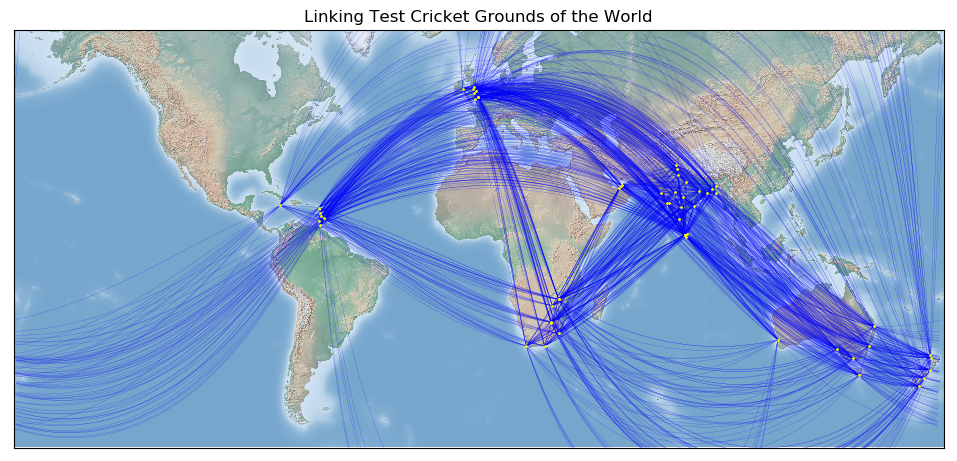

In [8]:
#Create a world map
plt.figure(figsize=(12, 9), dpi = 100)

#Define our map type and parameters
m = Basemap(projection='merc',llcrnrlat=-60,urcrnrlat=65,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution=None)

#Add shadedrelief image to the map
m.shadedrelief(scale=0.4)

#Draw our great circles by unpacking our tuple pairs
for ground_pair in ground_pairs:
    
    #Create coord variables for drawgreatcircle, note lat/lng order reversed
    lng1 = ground_pair[0][1]
    lat1 = ground_pair[0][0]
    lng2 = ground_pair[1][1]
    lat2 = ground_pair[1][0]
    
    #Draw our great circles
    m.drawgreatcircle(lng1, lat1, lng2, lat2, linewidth=0.1, color='b')

#Highlight the grounds locations
for ground in ground_tuples:
    xlng = ground[1]
    ylat = ground[0]
    
    m.plot(xlng, ylat, latlon='True', color='#FFFF00', marker='.', markersize=2)

#Show
plt.title("Linking Test Cricket Grounds of the World")
plt.show()

There we have it, a map of all test grounds linked.  It has an appealing global network look, but lacks functionality.  Labelling grounds would look messy as on a global scale they are located in bunched up groups. In a future post I'll use a different map package where we can zoom in and out, clicking on venues to display their names and any extra data.